In [1]:
pip install dython

Note: you may need to restart the kernel to use updated packages.


In [2]:
# data analysis and wrangling
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from dython.nominal import associations
from dython.nominal import identify_nominal_columns

In [3]:
# from wand.image import Image as WImage
# img = WImage(filename='/kaggle/input/welocalize/Welocalize - Assessment Instructions.pdf')
# img

# Assessment Criteria:
Testing your: 
- [ ] creativity
- [ ] analytics fundamentals
- [ ] technical knowledge
- [ ] communication
- [ ] connecting data to people/processes/business outcomes

1. How I create insights
2. How I communicate insights
3. Questions I ask Kevin/stakeholders before heading into analysis

# Problem:

* Interested in understanding how frequently we deliver to our customers on time, vs. how frequently we are late.
* What factors contribute to our on-time delivery (OTD) rates. --correlations
* And how we can do better at delivering on time? --theoretically and what data provides as delivery failure activity
* Also interested to know what other insights you can derive from this data (not necessarily related to OTD rates). --looking at translation service's main KPI's and what what provided data can answer other than delivery time; look at competitors' case studies

## Context around Problem:
    
* Why is this problem being investigated:

At times, Welocalize has put a lot of focus/effort onto <font color='red'>client retention and satisfaction</font>. And we've heard from clients that <font color='red'>worse-than-expected on-time delivery rates</font> is one of the biggest things that makes them dissatisfied.

* Company threshold for what is an alarming rate of tardy deliverables:

It varies by customer and by program, but the great majority of customers expect <font color='red'>90-95%</font> of deliverables to be delivered on time.

* What would be considered an improvement?

Meeting customers' expectations.

* What time interval are we measuring punctual/late deliveries (per month/per week)?

Again, it can vary; some high-volume customers/programs might look at it daily. But probably the most typical way to look at it is <font color='red'>by month</font>.


* Reason for heavy sparseness of data in column -average_duration_request_received_to_quoted_business_seconds:

Some projects are not quoted, because we have a <font color='red'>long-term contract with the client that allows us to skip the quoting process</font>, and start work on all their requests/projects immediately, without any quote (and quote approval) process. If there is no quote for a given project, then there is no duration here.

In [4]:
data = pd.read_excel(r'/kaggle/input/welocalize/welocalize_dataset.xlsx', sheet_name= 'data')
data

,client_deliverable_id,date_client_deliverable_delivered,total_tasks,words,average_duration_request_received_to_quoted_business_seconds,average_duration_offer_sent_to_task_claimed_seconds,average_duration_task_claimed_to_task_started_seconds,translations_for_client_by_supplier_to_date,source_language_locale_code,target_language_locale_code,project_manager_id,requests_managed_simultaneously_by_project_manager,content_specialty,translation_supplier_id,service_line,lateness_of_client_deliverable_seconds,is_client_deliverable_past_due
0,1639999,2022-02-02,11,21354,5572.340,103048.0,124904.0,1,en-US,ja-JP,3424244246268217782,816,Chemistry,Pantheon_11922,Legal & Financial Services,NaN,N
1,1658115,2022-02-01,8,1344,5771.707,157246.0,188189.0,33,en-US,sq-AL,3908128739217598266,324,Chemistry,Pantheon_5920,Legal & Financial Services,NaN,N
2,1658124,2022-02-01,12,20714,5771.707,352535.0,205806.0,13,en-US,el-GR,3908128739217598266,324,Chemistry,Pantheon_5881,Legal & Financial Services,NaN,N
3,1658129,2022-02-01,7,1344,5771.707,204319.0,193394.0,16,en-US,lt-LT,3908128739217598266,324,Chemistry,Pantheon_5922,Legal & Financial Services,NaN,N
4,1658134,2022-02-01,10,20714,5771.707,354784.0,339963.0,8,en-US,pt-PT,3908128739217598266,324,Chemistry,Pantheon_6813,Legal & Financial Services,NaN,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99694,5406402,2022-12-30,2,9,NaN,191.0,2026.0,112,en-US,ru-RU,6712390449850189908,17,Marketing,Pantheon_913,Localization,NaN,N
99695,5406925,2022-12-30,1,2,NaN,633.0,2.0,287,en-US,cs-CZ,1201051988300040006,34,Marketing,Pantheon_29997,Localization,NaN,N
99696,5407305,2022-12-30,2,50,NaN,NaN,713.0,831,en-US,ro-RO,2341318023614218099,181,Marketing,Pantheon_835,Localization,NaN,N
99697,5407454,2022-12-30,2,16,NaN,663.0,147.0,349,en-US,it-IT,2341318023614218099,179,Marketing,Pantheon_160,Localization,NaN,N


In [5]:
data.shape

(99699, 17)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99699 entries, 0 to 99698
Data columns (total 17 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   client_deliverable_id                                         99699 non-null  int64  
 1   date_client_deliverable_delivered                             99699 non-null  object 
 2   total_tasks                                                   99699 non-null  int64  
 3   words                                                         99699 non-null  int64  
 4   average_duration_request_received_to_quoted_business_seconds  1579 non-null   float64
 5   average_duration_offer_sent_to_task_claimed_seconds           92870 non-null  float64
 6   average_duration_task_claimed_to_task_started_seconds         98391 non-null  float64
 7   translations_for_client_by_supplier_to_date                   99699

In [7]:
data.isnull().sum()

client_deliverable_id                                               0
date_client_deliverable_delivered                                   0
total_tasks                                                         0
words                                                               0
average_duration_request_received_to_quoted_business_seconds    98120
average_duration_offer_sent_to_task_claimed_seconds              6829
average_duration_task_claimed_to_task_started_seconds            1308
translations_for_client_by_supplier_to_date                         0
source_language_locale_code                                         0
target_language_locale_code                                         0
project_manager_id                                                  0
requests_managed_simultaneously_by_project_manager                  0
content_specialty                                                   0
translation_supplier_id                                             0
service_line        

# SQL Pre-processing. Code here:
1. The dataset is of mixed granularity. Below are views created after separating out deliverable info from requests and translation task info. Requests comprise of multiple deliverables (if separate requests joined to separate deliverables table: one-to-many relationship). And deliverables have multiple tasks which can include a translation task (in this dataset, only translation tasks are included. so if separate deliverables table was joined to tasks table, would create a many-to-many relationship). 
2. Taking out NULL values from is_client_deliverable_past_due (2 rows only; low % of whole dataset)
3. Transforming data into correct data given column logic (boolean -> TRUE/FALSE)
4. Creating consistent precision (round to nearest seconds vs having seconds to thousandth's place)

In [8]:
requests = pd.read_csv('/kaggle/input/welocalize/requests.csv')
deliverables = pd.read_csv('/kaggle/input/welocalize/deliverables.csv')
translation_task = pd.read_csv('/kaggle/input/welocalize/translation_task.csv')

# CLASSIFYING

# CORRELATING

# CHARTING

# Starting with deliverables:

* Categorical:    
date_client_deliverable_delivered, is_client_deliverable_past_due  

* Numerical:
total_tasks, words, average_duration_offer_sent_to_task_claimed_seconds, average_duration_task_claimed_to_task_started_seconds, lateness_of_client_deliverable_seconds 

* Columns with errors:
There are no mixed data types. And features were corrected for Boolean column to have Boolean types and seconds measurements consistently rounded to tenths place.

Columns with blanks, null or empty values: The original dataset showed huge amount of sparseness in column: average_duration_request_received_to_quoted_business_seconds. So not much can be derived from this other than business is doing well if requests do not need quote before starting work on requests.

In [9]:
deliverables.shape

(99697, 11)

In [10]:
deliverables.head()

,client_deliverable_id,date_client_deliverable_delivered,total_tasks,words,average_duration_offer_sent_to_task_claimed_seconds,average_duration_offer_sent_to_task_claimed_hours,average_duration_task_claimed_to_task_started_seconds,average_duration_task_claimed_to_task_started_days,lateness_of_client_deliverable_seconds,lateness_of_client_deliverable_days,is_client_deliverable_past_due
0,1639999,2022-02-02,11,21354,103048.0,28.624444,124904.0,1.445648,NaN,NaN,False
1,1658115,2022-02-01,8,1344,157246.0,43.679444,188189.0,2.178113,NaN,NaN,False
2,1658124,2022-02-01,12,20714,352535.0,97.926389,205806.0,2.382014,NaN,NaN,False
3,1658129,2022-02-01,7,1344,204319.0,56.755278,193394.0,2.238356,NaN,NaN,False
4,1658134,2022-02-01,10,20714,354784.0,98.551111,339963.0,3.934757,NaN,NaN,False


In [11]:
deliverables.isnull().sum()

client_deliverable_id                                        0
date_client_deliverable_delivered                            0
total_tasks                                                  0
words                                                        0
average_duration_offer_sent_to_task_claimed_seconds       6828
average_duration_offer_sent_to_task_claimed_hours         6828
average_duration_task_claimed_to_task_started_seconds     1307
average_duration_task_claimed_to_task_started_days        1307
lateness_of_client_deliverable_seconds                   90260
lateness_of_client_deliverable_days                      90260
is_client_deliverable_past_due                               0
dtype: int64

In [12]:
# Distribution of numerical features:`

deliverables[['total_tasks',
 'words',
 'average_duration_offer_sent_to_task_claimed_hours',
 'average_duration_task_claimed_to_task_started_days',
 'lateness_of_client_deliverable_days']].describe()

,total_tasks,words,average_duration_offer_sent_to_task_claimed_hours,average_duration_task_claimed_to_task_started_days,lateness_of_client_deliverable_days
count,99697.000000,99697.000000,92869.000000,98390.000000,9437.000000
mean,2.940700,1366.244441,15.161682,1.402456,10.326718
std,2.003716,6286.567791,36.195716,2.442345,16.522251
min,1.000000,0.000000,0.000278,0.000000,0.000014
25%,2.000000,24.000000,0.726944,0.116438,1.110137
50%,2.000000,120.000000,4.015278,0.611447,4.815762
75%,3.000000,578.000000,13.348611,1.680883,11.629934
max,61.000000,257709.000000,974.623611,75.913426,289.416480


* Total samples: 99699
* Average 3 tasks/deliverable with minimum 1 task and at most 61 tasks
* Average amount of words translated in deliverable: 1366
* Average time it takes for Welocalize to accept task: 54581 seconds/15 hours with max time: 40 days
* Average time it takes for Welocalize to start accepted task: 1.4 days
* Average late time on delivery: 10.3 days

In [13]:
# Distribution of categorical features:

deliverables.describe(include=['O'])

,date_client_deliverable_delivered
count,99697
unique,364
top,2022-10-19
freq,571


* date delivered:
** sample is almost whole year: 2022
** looks like there was a huge deadline/submissions on 10/19
* flag for client deliverable being past due date:
** two missing values
** majority of deliverables are not late

# Visualizations

In [14]:
# Time Interval We are Looking At

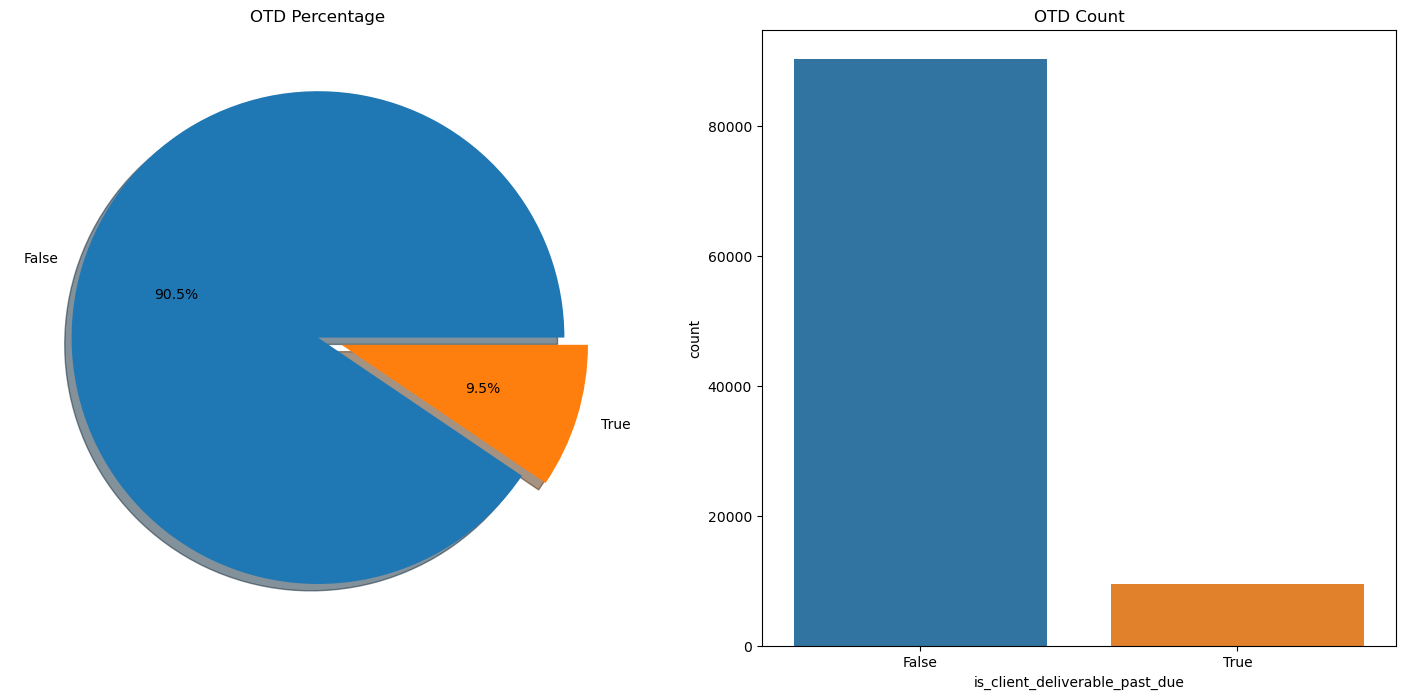

In [15]:
# How Many Delivered On Time?

f,ax=plt.subplots(1,2,figsize=(18,8))
deliverables['is_client_deliverable_past_due'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('OTD Percentage')
ax[0].set_ylabel('')
sns.countplot(x = 'is_client_deliverable_past_due',data=deliverables,ax=ax[1]) 
ax[1].set_title('OTD Count')
plt.show()

Percentage of non-OTD is around 10%. And after some discussion with stakeholder, customer expects 90-95% deliverables to be on time even though Welocalize aims for 100%. So year 2022 OTD metric was within range, but there is still room for improvement. 

# Analyzing Columns That Could Contribute to Delivery Time

# Reminder

Categorical:
date_client_deliverable_delivered

Numerical: total_tasks, words, average_duration_offer_sent_to_task_claimed_seconds, average_duration_task_claimed_to_task_started_seconds, lateness_of_client_deliverable_seconds

Columns with errors: There are no mixed data types. And features were corrected for Boolean column to have Boolean types and seconds measurements consistently rounded to tenths place.

In [16]:
# Dataset Timeframe
deliverables.date_client_deliverable_delivered.min(), deliverables.date_client_deliverable_delivered.max()


('2022-01-01', '2022-12-30')

Total timeframe of data is 354 days from year: 2022.

In [17]:
# Let's get different trends of OTD and non-OTD broken down by month and week.
monthly = pd.read_csv('/kaggle/input/welocalize/month_freqs.csv')
weekly = pd.read_csv('/kaggle/input/welocalize/week_freqs.csv')
month_day = pd.read_csv('/kaggle/input/welocalize/day_freqs.csv')
dow = pd.read_csv('/kaggle/input/welocalize/dow_freqs.csv')

OTD percent is total # of on time deliverables over total deliverables and for non-OTD vice versa.

### Monthly:

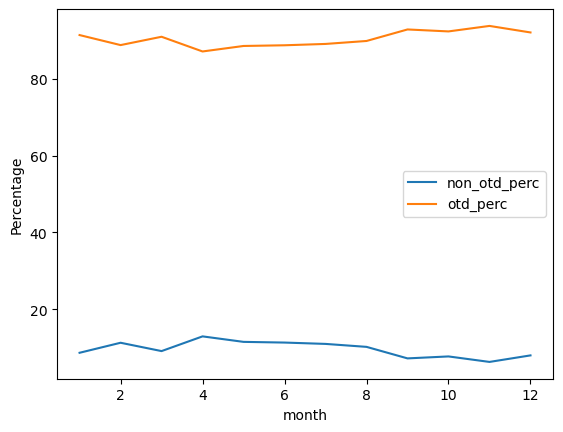

In [18]:
monthly.plot(x="month", y=["non_otd_perc", "otd_perc"])
plt.ylabel('Percentage')
plt.show()

This just shows us how big of a difference there is between OTD's and non-OTD's. 

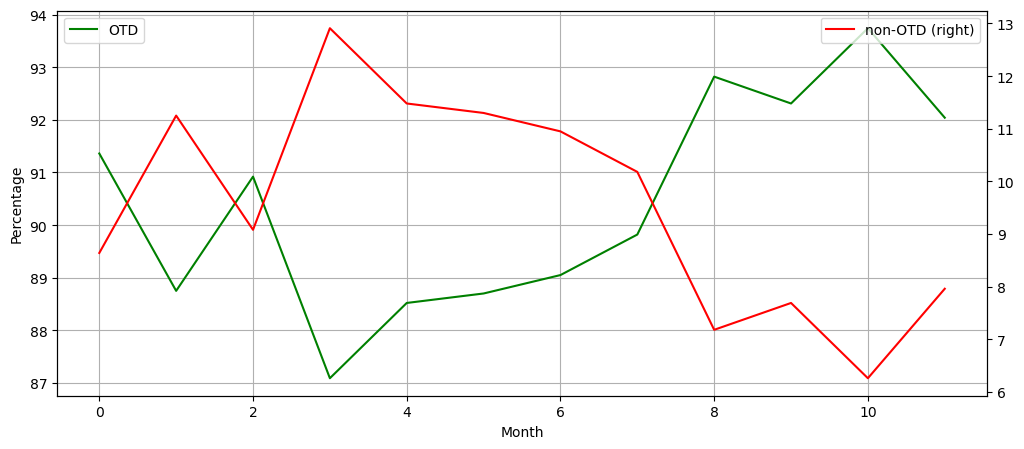

In [19]:
plt.figure(figsize=(12,5))
plt.xlabel('Month')
plt.ylabel('Percentage')

ax1 = monthly.otd_perc.plot(color='green', grid=True, label='OTD')
ax2 = monthly.non_otd_perc.plot(color='red', grid=True, secondary_y=True, label='non-OTD')

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.show()

This graph is more illuminating because it let's us see better inflections within each percentage and between OTD's and non-OTD's, when trend is down, what is the relationship with the other graph. 

## Observation:
As we can see here is that OTD's hit a low in March and have peaked after that with a slight dip at end of the year. Would be interesting to see what contributed to non-OTD's in March and peak of OTD's in October.

### Weekly:

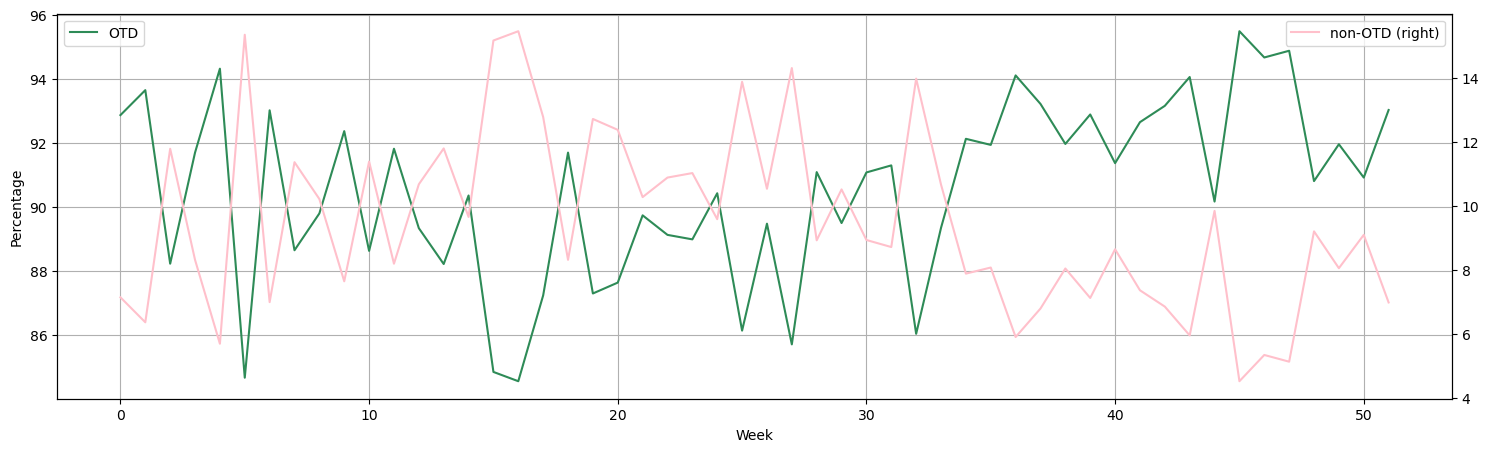

In [20]:
plt.figure(figsize=(18,5))
plt.xlabel('Week')
plt.ylabel('Percentage')

ax1 = weekly.otd_perc.plot(color='seagreen', grid=True, label='OTD')
ax2 = weekly.non_otd_perc.plot(color='pink', grid=True, secondary_y=True, label='non-OTD')

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.show()

## Observation:

It gets more interesting at the weekly level. At this level of granularity, we see OTD's drop significantly every 10 weeks until appoximately 32nd week of 2022/August.

### Day of Month:

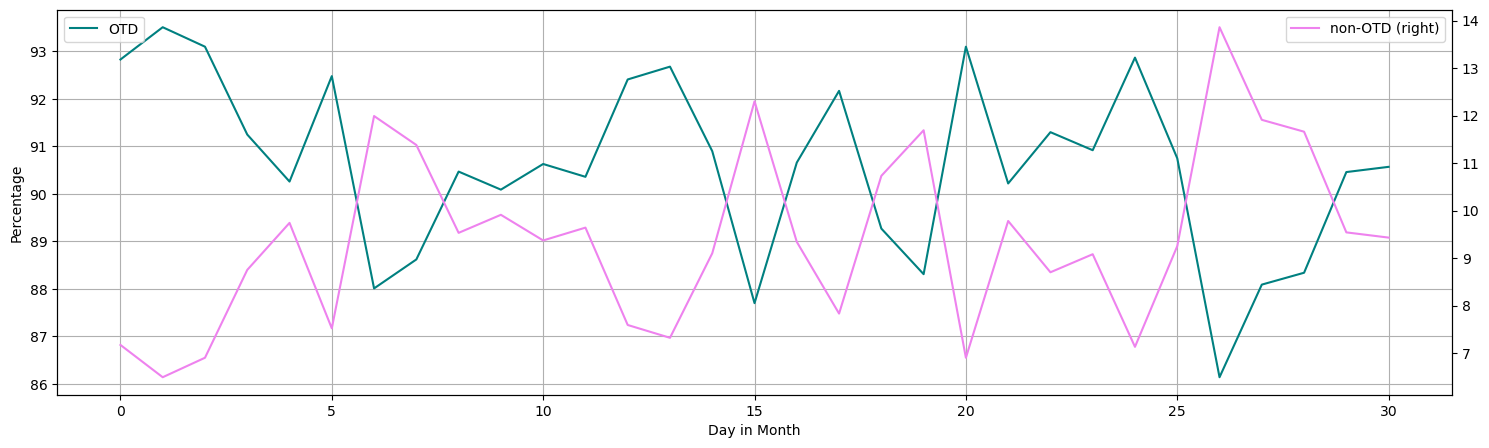

In [21]:
plt.figure(figsize=(18,5))
plt.xlabel('Day in Month')
plt.ylabel('Percentage')

ax1 = month_day.otd_perc.plot(color='teal', grid=True, label='OTD')
ax2 = month_day.non_otd_perc.plot(color='violet', grid=True, secondary_y=True, label='non-OTD')

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.show()

### Observations:

### Day of Week:

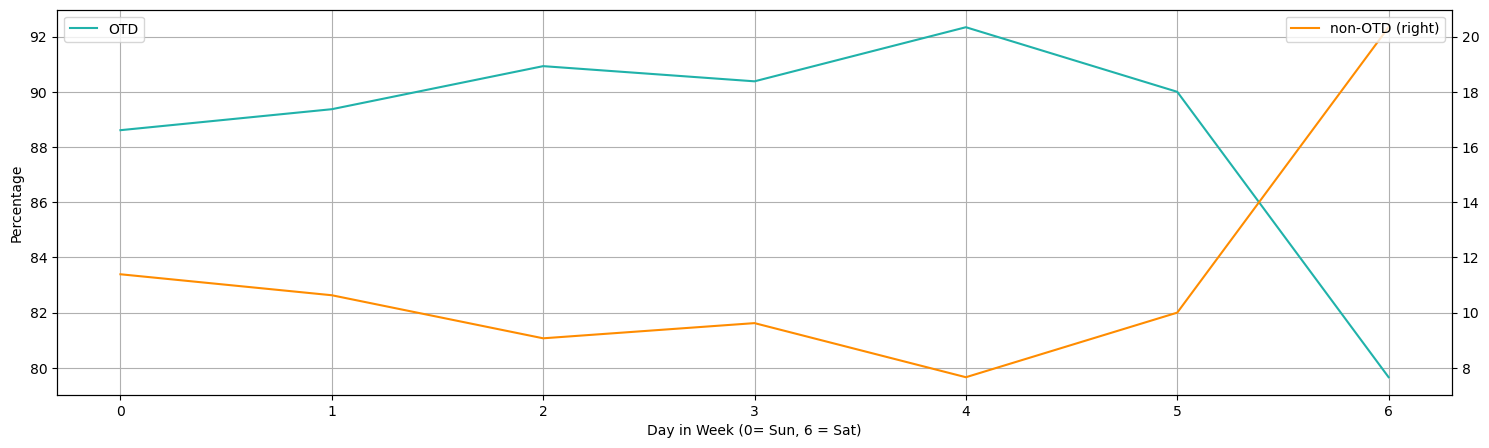

In [22]:
plt.figure(figsize=(18,5))
plt.xlabel('Day in Week (0= Sun, 6 = Sat)')
plt.ylabel('Percentage')

ax1 = dow.otd_perc.plot(color='lightseagreen', grid=True, label='OTD')
ax2 = dow.non_otd_perc.plot(color='darkorange', grid=True, secondary_y=True, label='non-OTD')

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.show()

### Observation: Does not look like there are any interesting patterns/insights at day of month/day in week level.

In [23]:
deliverables.head()

,client_deliverable_id,date_client_deliverable_delivered,total_tasks,words,average_duration_offer_sent_to_task_claimed_seconds,average_duration_offer_sent_to_task_claimed_hours,average_duration_task_claimed_to_task_started_seconds,average_duration_task_claimed_to_task_started_days,lateness_of_client_deliverable_seconds,lateness_of_client_deliverable_days,is_client_deliverable_past_due
0,1639999,2022-02-02,11,21354,103048.0,28.624444,124904.0,1.445648,NaN,NaN,False
1,1658115,2022-02-01,8,1344,157246.0,43.679444,188189.0,2.178113,NaN,NaN,False
2,1658124,2022-02-01,12,20714,352535.0,97.926389,205806.0,2.382014,NaN,NaN,False
3,1658129,2022-02-01,7,1344,204319.0,56.755278,193394.0,2.238356,NaN,NaN,False
4,1658134,2022-02-01,10,20714,354784.0,98.551111,339963.0,3.934757,NaN,NaN,False


Reminder
Categorical: date_client_deliverable_delivered

Numerical: total_tasks, words, average_duration_offer_sent_to_task_claimed_seconds, average_duration_task_claimed_to_task_started_seconds, lateness_of_client_deliverable_seconds

Columns with errors: There are no mixed data types. And features were corrected for Boolean column to have Boolean types and seconds measurements consistently rounded to tenths place.

# Continous Data
### Total Tasks 

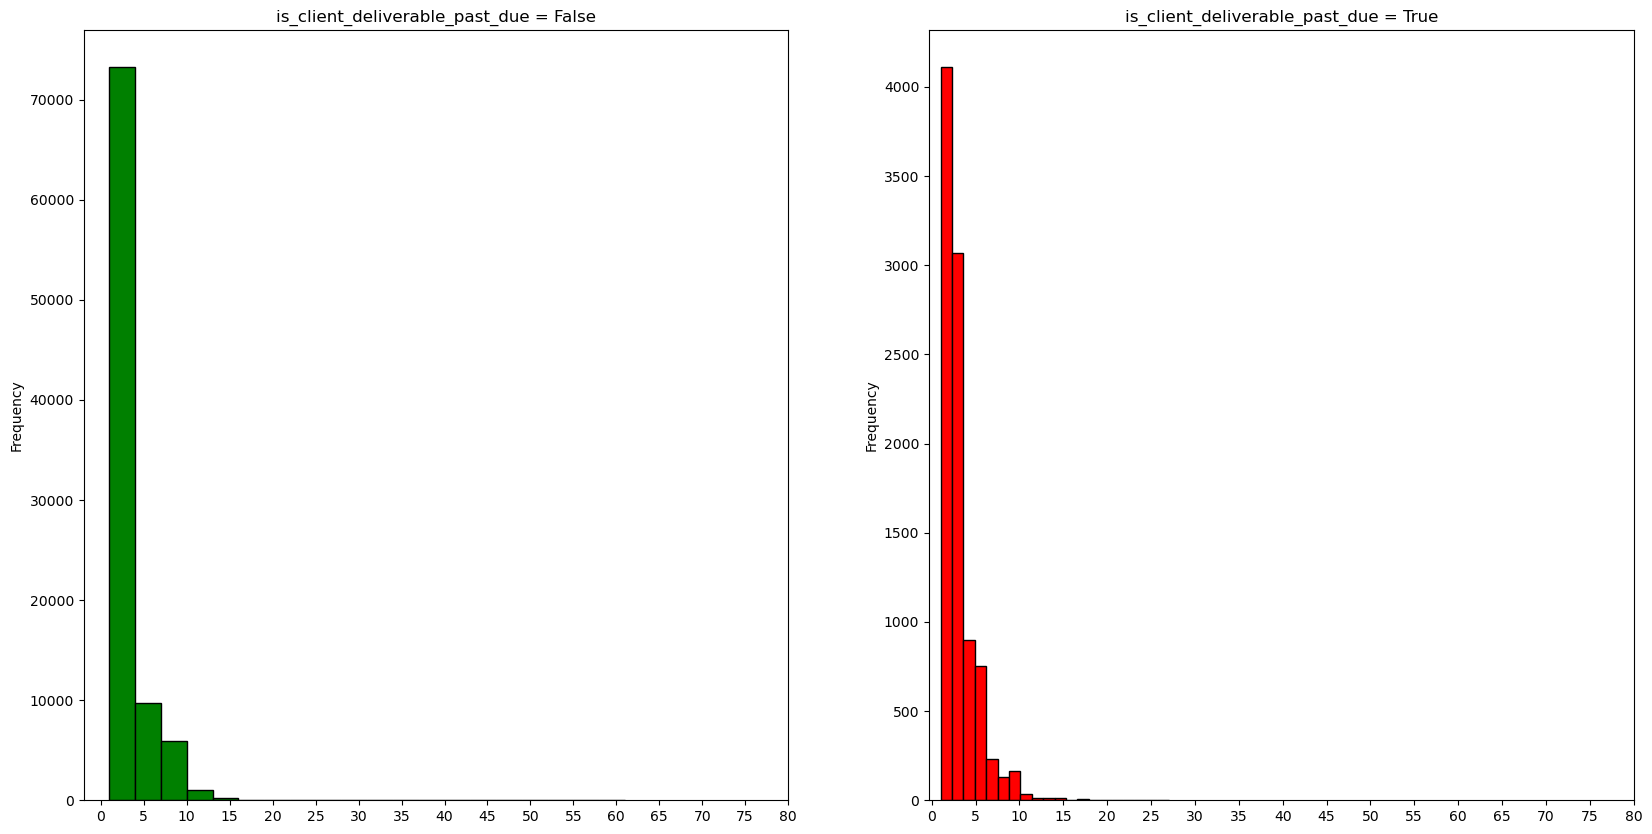

In [24]:
f,ax=plt.subplots(1,2,figsize=(20,10))
deliverables[deliverables['is_client_deliverable_past_due']==False].total_tasks.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='green')
ax[0].set_title('is_client_deliverable_past_due = False')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
deliverables[deliverables['is_client_deliverable_past_due']==True].total_tasks.plot.hist(ax=ax[1],bins=20,edgecolor='black',color='red')
ax[1].set_title('is_client_deliverable_past_due = True')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

### Observations:
1. For deliverables that were not delivered on time, more variety of total tasks per deliverable. 
2. Though both deliverables delivered on time and not on time are left skewed meaning most deliverables have low number of tasks. 
3. Most number of tasks for OTD was 15.
4. Most number of tasks for non-OTD was between 15 and 20. Looks like going beyond 15 did not help with OTD.

### Words, Average duration offer sent to task claimed hours, Average duration task claimed to task started days, Lateness of client deliverable days

In [25]:
deliverables_otd = deliverables.loc[deliverables['is_client_deliverable_past_due'] == False]
deliverables_non_otd = deliverables.loc[deliverables['is_client_deliverable_past_due'] == True]
deliverables_otd2 = deliverables_otd[['words', 'average_duration_offer_sent_to_task_claimed_hours', 'average_duration_task_claimed_to_task_started_days']]
deliverables_non_otd2 = deliverables_non_otd[['words', 'average_duration_offer_sent_to_task_claimed_hours', 'average_duration_task_claimed_to_task_started_days', 'lateness_of_client_deliverable_days']]

<AxesSubplot:>

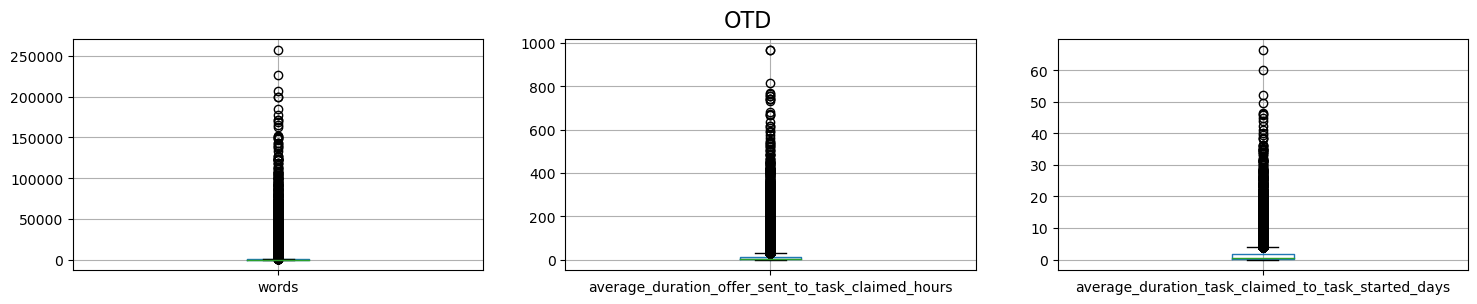

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(18, 3))
fig.suptitle('OTD', fontsize=16)
deliverables_otd2.boxplot('words', ax=ax[0])
deliverables_otd2.boxplot('average_duration_offer_sent_to_task_claimed_hours', ax=ax[1])
deliverables_otd2.boxplot('average_duration_task_claimed_to_task_started_days', ax=ax[2])

<AxesSubplot:>

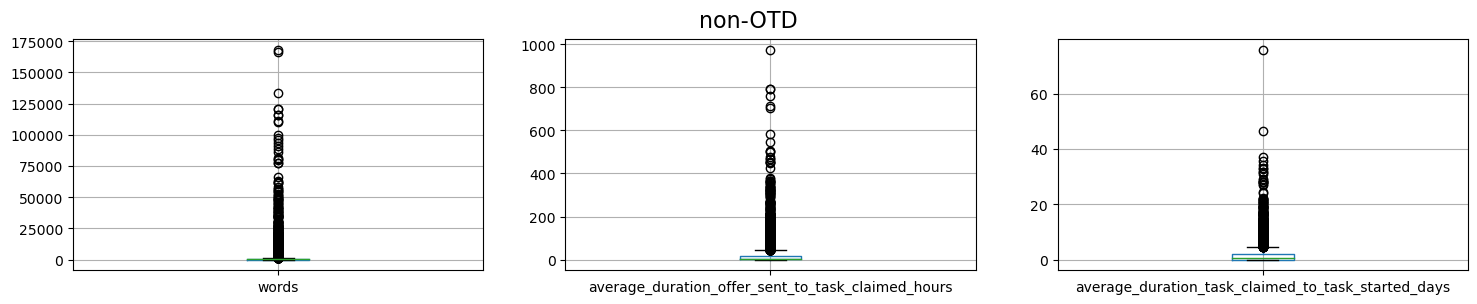

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(18, 3))
fig.suptitle('non-OTD', fontsize=16)
deliverables_non_otd2.boxplot('words', ax=ax[0])
deliverables_non_otd2.boxplot('average_duration_offer_sent_to_task_claimed_hours', ax=ax[1])
deliverables_non_otd2.boxplot('average_duration_task_claimed_to_task_started_days', ax=ax[2])

### Observations
1. All distibutions have long upper whisker/outliers; lot of variance
2. Bulk of the outliers for total words in non-OTD is at lower total number of words (about half)
3. Max total words for OTD is approximately 75,000 more words
4. Took worker longer to accept task for OTD's. (More vetted)
5. Took OTD tasks' longer to start with wider range of outliers within 40-day timespan (More deliberation)

Text(0.5, 0, 'Lateness of Client Deliverable (Days)')

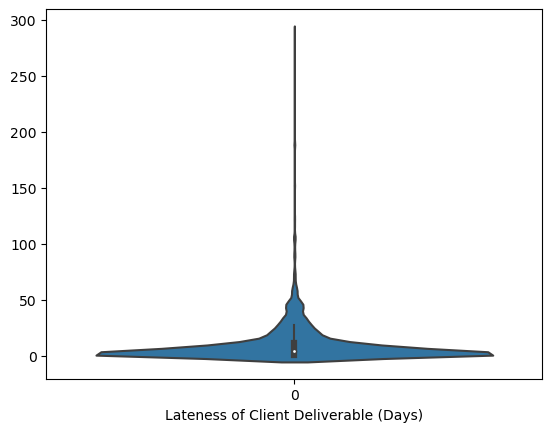

In [28]:
# lateness of delivery in days
sns.violinplot(deliverables.lateness_of_client_deliverable_days)
plt.xlabel("Lateness of Client Deliverable (Days)")

In [29]:
deliverables.lateness_of_client_deliverable_days.value_counts()

19.628054    24
11.629934    22
15.109029    21
25.396868    19
20.586388    16
             ..
4.403264      1
4.530662      1
5.317398      1
2.575194      1
0.001356      1
Name: lateness_of_client_deliverable_days, Length: 8720, dtype: int64

In [30]:
deliverables.lateness_of_client_deliverable_days.describe()

count    9437.000000
mean       10.326718
std        16.522251
min         0.000014
25%         1.110137
50%         4.815762
75%        11.629934
max       289.416480
Name: lateness_of_client_deliverable_days, dtype: float64

### Observation:
1. Most of the time, late delivery times were 10 days.
2. At the same time, there are some outliers that could be taken out such as maximum late time extending all the way out to about 10.5 months

### Correlations with OTD

### Before creating correlation matrix, need to create new columns:
* from delivery date: monthly, weekly columns
* change is_client_deliverable_past_due (True/False) to OTD (0/1) - (True late means 0 for OTD column)
* leave out primary key
* only include time aggregatons at highest level of granularity

In [31]:
deliverables2 = deliverables.copy()

deliverables2['date_client_deliverable_delivered'] = pd.to_datetime(deliverables2['date_client_deliverable_delivered'])
deliverables2['date_client_deliverable_delivered_month'] = deliverables2['date_client_deliverable_delivered'].dt.month
deliverables2['date_client_deliverable_delivered_week'] = deliverables2['date_client_deliverable_delivered'].dt.isocalendar().week

deliverables2['is_client_deliverable_past_due'] = deliverables2['is_client_deliverable_past_due'].astype(int)
deliverables2['OTD'] = deliverables2['is_client_deliverable_past_due'].replace({0:1, 1:0})


deliverables3 = deliverables2[['date_client_deliverable_delivered_month', 'date_client_deliverable_delivered_week', 'total_tasks', 'words', 'average_duration_offer_sent_to_task_claimed_hours', 'average_duration_task_claimed_to_task_started_days', 'lateness_of_client_deliverable_days', 'OTD']]

In [32]:
categorical_features=identify_nominal_columns(deliverables3)
categorical_features

[]

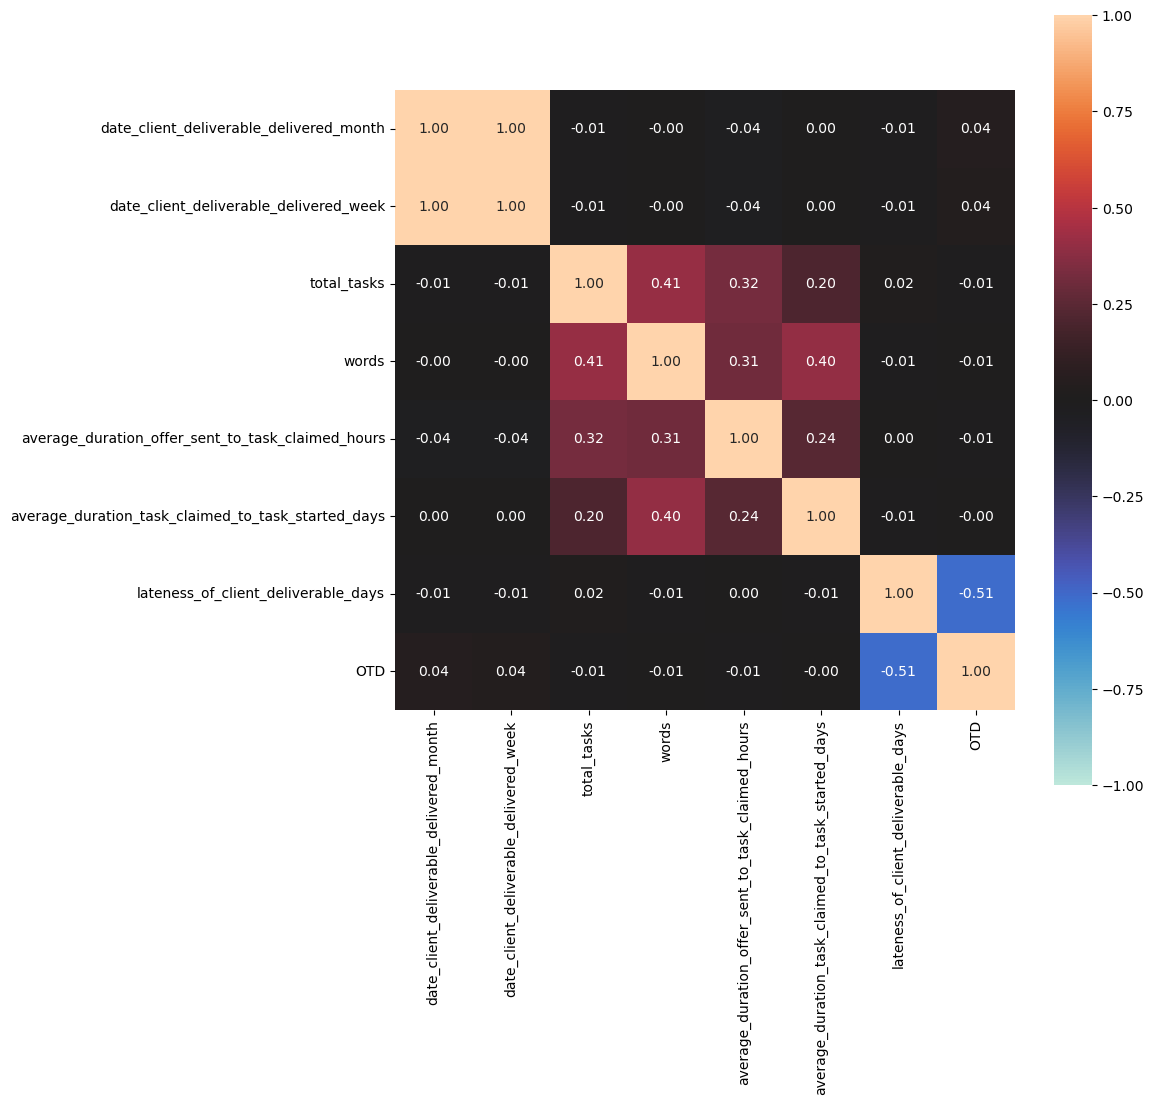

{'corr':                                                     date_client_deliverable_delivered_month  \
 date_client_deliverable_delivered_month                                            1.000000   
 date_client_deliverable_delivered_week                                             0.995910   
 total_tasks                                                                       -0.011438   
 words                                                                             -0.004182   
 average_duration_offer_sent_to_task_claimed_hours                                 -0.036995   
 average_duration_task_claimed_to_task_started_days                                 0.002261   
 lateness_of_client_deliverable_days                                               -0.012564   
 OTD                                                                                0.041016   
 
                                                     date_client_deliverable_delivered_week  \
 date_client_deliverable_delive

In [33]:
complete_correlation= associations(deliverables3, figsize=(10,10))
complete_correlation

## Observations in a Nutshell for all Deliverables Columns

# Checking all observatons from EDA with correlation Heatmap

Reminder on how to determine Correlation:
    
POSITIVE CORRELATION: If an increase in column A leads to increase in column B, then they are positively correlated. A value 1 means perfect positive correlation.

NEGATIVE CORRELATION: If an increase in column A leads to decrease in column B, then they are negatively correlated. A value -1 means perfect negative correlation.

At the same time, two columns can have highly/perfect correlation meaning no variation in information. This is known as **MultiColinearity** as both columns contain the same information.

Take-away's from deliverables' specific columns:
* What we observe here is that there is not much correlation. 
* Highest correlations are around the relationship that bigger tasks, have more words translated, longer time to claim task and takes longer to start task.
* Highest correlation is **0.41 between total tasks and words**. 

# Other Insights
## Requests

* Project manager can have multiple deliverables. 
* And these can be delivered on time or not.
* So focus is on requests, but data is fanned out since working at request level that consists of multiple deliverables (one to many rel)

In [34]:
requests2 = requests[['average_duration_request_received_to_quoted_business_days', 'project_manager_id','requests_managed_simultaneously_by_project_manager','service_line','is_client_deliverable_past_due']]
requests2.head()

,average_duration_request_received_to_quoted_business_days,project_manager_id,requests_managed_simultaneously_by_project_manager,service_line,is_client_deliverable_past_due
0,0.064494,3424244246268217782,816,Legal & Financial Services,False
1,0.066802,3908128739217598266,324,Legal & Financial Services,False
2,0.066802,3908128739217598266,324,Legal & Financial Services,False
3,0.066802,3908128739217598266,324,Legal & Financial Services,False
4,0.066802,3908128739217598266,324,Legal & Financial Services,False


In [35]:
requests2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99697 entries, 0 to 99696
Data columns (total 5 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   average_duration_request_received_to_quoted_business_days  1579 non-null   float64
 1   project_manager_id                                         99697 non-null  int64  
 2   requests_managed_simultaneously_by_project_manager         99697 non-null  int64  
 3   service_line                                               99697 non-null  object 
 4   is_client_deliverable_past_due                             99697 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 3.1+ MB


In [36]:
requests2[['average_duration_request_received_to_quoted_business_days','requests_managed_simultaneously_by_project_manager','is_client_deliverable_past_due']].describe()

,average_duration_request_received_to_quoted_business_days,requests_managed_simultaneously_by_project_manager
count,1579.000000,99697.000000
mean,2.295781,221.800907
std,13.384030,771.741312
min,0.000000,1.000000
25%,0.053655,28.000000
50%,0.140162,55.000000
75%,0.369256,103.000000
max,166.223669,5759.000000


In [37]:
requests2.isnull().sum()

average_duration_request_received_to_quoted_business_days    98118
project_manager_id                                               0
requests_managed_simultaneously_by_project_manager               0
service_line                                                     0
is_client_deliverable_past_due                                   0
dtype: int64

### Observations:
* Remember, average_duration_request_received_to_quoted_business_days is heavily sparse because not a strict requirement for tasks to get started if client has been one for a while.
* With sparse data in that column, usually takes 2 days to get quote for client.
* Average number of requests managed by one project manager is huge: 222 with the max close to 6000. 

### Types of Columns:

* Categorical: service_line, is_client_deliverable_past_due 
* Ordinal: project_manager_id
* Continuous: average_duration_request_received_to_quoted_business_days, requests_managed_simultaneously_by_project_manager 

### Service Line 

In [38]:
requests2.groupby(['service_line','is_client_deliverable_past_due'])['is_client_deliverable_past_due'].count()

service_line                is_client_deliverable_past_due
Legal & Financial Services  False                              5635
                            True                                310
Life Sciences               False                              8675
                            True                                429
Localization                False                             75935
                            True                               8713
Name: is_client_deliverable_past_due, dtype: int64

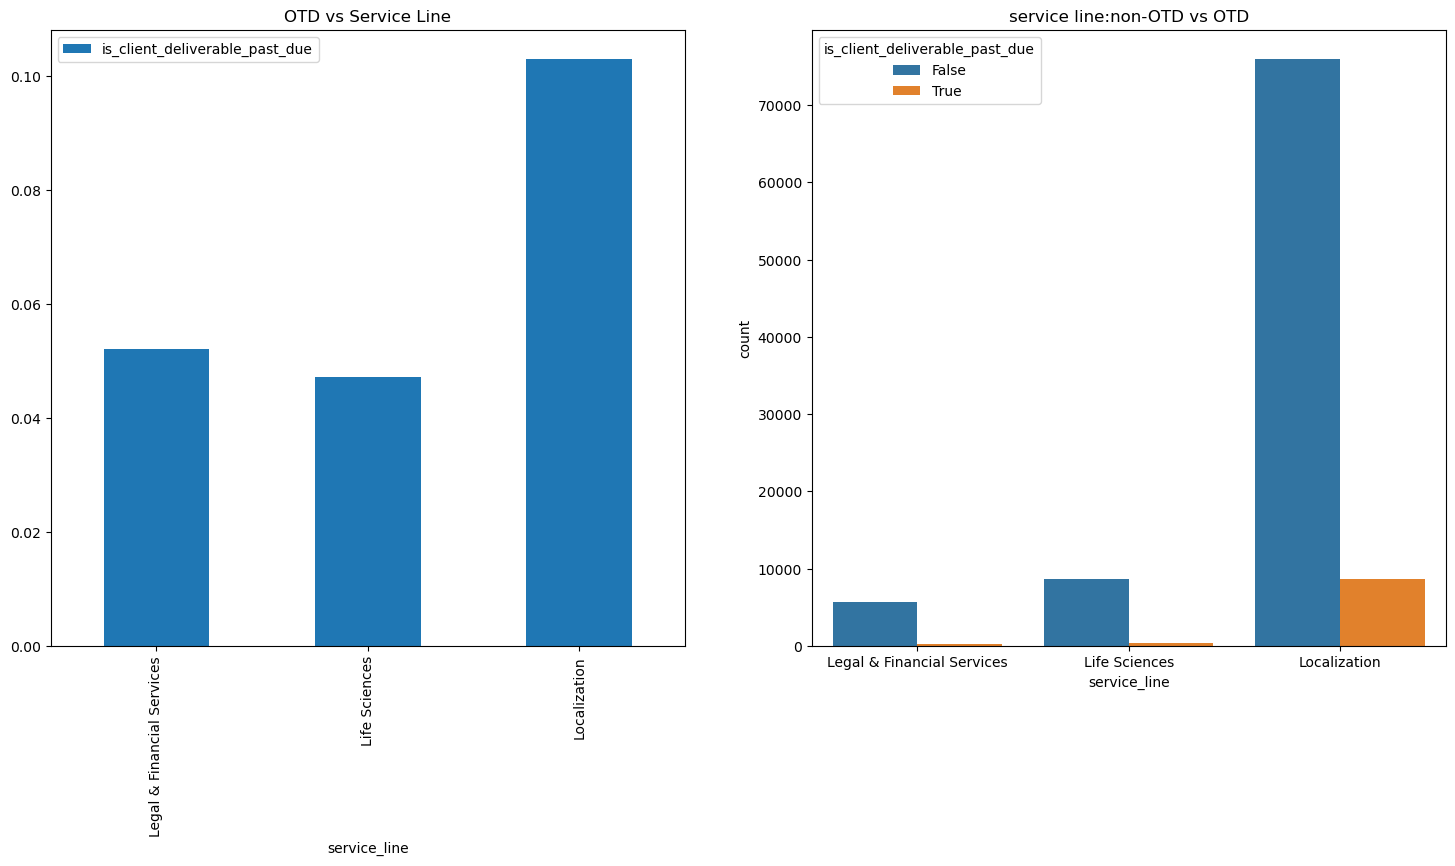

In [39]:
f,ax=plt.subplots(1,2,figsize=(18,8))
requests2[['service_line','is_client_deliverable_past_due']].groupby(['service_line']).mean().plot.bar(ax=ax[0])
ax[0].set_title('OTD vs Service Line')
sns.countplot(x='service_line',hue='is_client_deliverable_past_due',data=requests2,ax=ax[1])
ax[1].set_title('service line:non-OTD vs OTD')
plt.show()

* Localization deliverables are highest in number.
* Localization has the highest number of non-OTD's as well as the highest difference between OTD and non-OTD deliverables.

### Project Manager ID

In [40]:
list(requests2)

['average_duration_request_received_to_quoted_business_days',
 'project_manager_id',
 'requests_managed_simultaneously_by_project_manager',
 'service_line',
 'is_client_deliverable_past_due']

In [41]:
requests2_otd = requests2.loc[requests2['is_client_deliverable_past_due'] == False]
requests2_nonotd = requests2.loc[requests2['is_client_deliverable_past_due'] == True]

<AxesSubplot:>

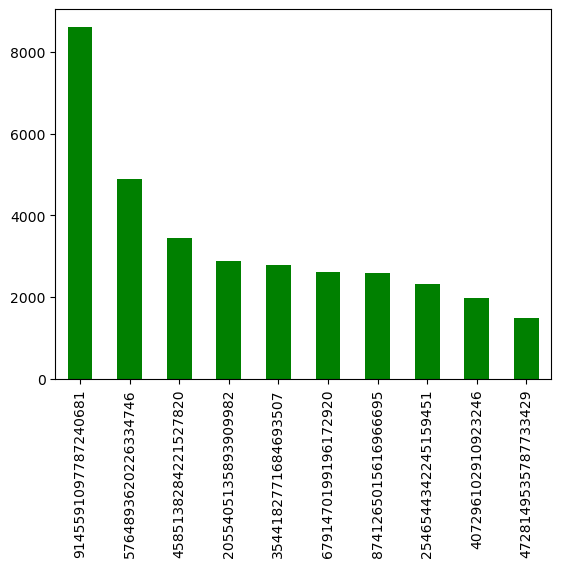

In [42]:
requests2_otd.project_manager_id.value_counts()[:10].plot(kind='bar', color='green')

<AxesSubplot:>

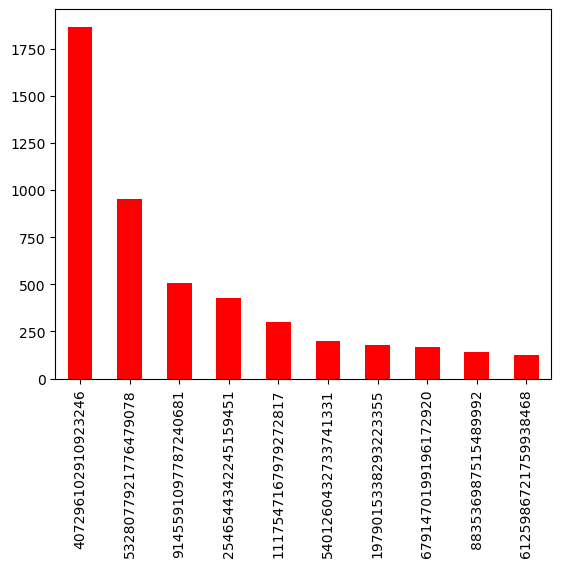

In [43]:
requests2_nonotd.project_manager_id.value_counts()[:10].plot(kind='bar', color = 'red')

Let's see how many projects these project managers have on their plate?

In [44]:
bad_pm = requests2_nonotd.project_manager_id.value_counts()[:10].index
bad_pm_deliverables = requests2[requests2['project_manager_id'].isin(bad_pm)]
bad_pm_deliverables.groupby('project_manager_id')['requests_managed_simultaneously_by_project_manager'].max().reset_index()

,project_manager_id,requests_managed_simultaneously_by_project_manager
0,407296102910923246,5759
1,883536987515489992,245
2,1117547167979272817,184
3,1979015338293223355,143
4,2546544342245159451,141
5,5328077921776479078,780
6,5401260432733741331,383
7,6125986721759938468,75
8,6791470199196172920,65
9,9145591097787240681,600


Comparing this to those who have delivered their deliverables on time:

In [45]:
good_pm = requests2_otd.project_manager_id.value_counts()[:10].index
good_pm_deliverables = requests2[requests2['project_manager_id'].isin(good_pm)]
good_pm_deliverables.groupby('project_manager_id')['requests_managed_simultaneously_by_project_manager'].max().reset_index()

,project_manager_id,requests_managed_simultaneously_by_project_manager
0,407296102910923246,5759
1,2055405135893909982,76
2,2546544342245159451,141
3,3544182771684693507,1535
4,4585138284221527820,84
5,4728149535787733429,229
6,5764893620226334746,256
7,6791470199196172920,65
8,8741265015616966695,122
9,9145591097787240681,600


In [46]:
requests2_otd.project_manager_id.value_counts()[:10].index.isin(bad_pm)

array([ True, False, False, False, False,  True, False,  True,  True,
       False])

Looks like there are project managers who are delivering on time and not on time. Would be good to see correlation matrix to see what sort of request attribute may contribute most to otd/non-otd.

### Average duration request received to quoted business days

In [47]:
#Let's remind ourselves of the dist
requests2.average_duration_request_received_to_quoted_business_days.describe()

count    1579.000000
mean        2.295781
std        13.384030
min         0.000000
25%         0.053655
50%         0.140162
75%         0.369256
max       166.223669
Name: average_duration_request_received_to_quoted_business_days, dtype: float64

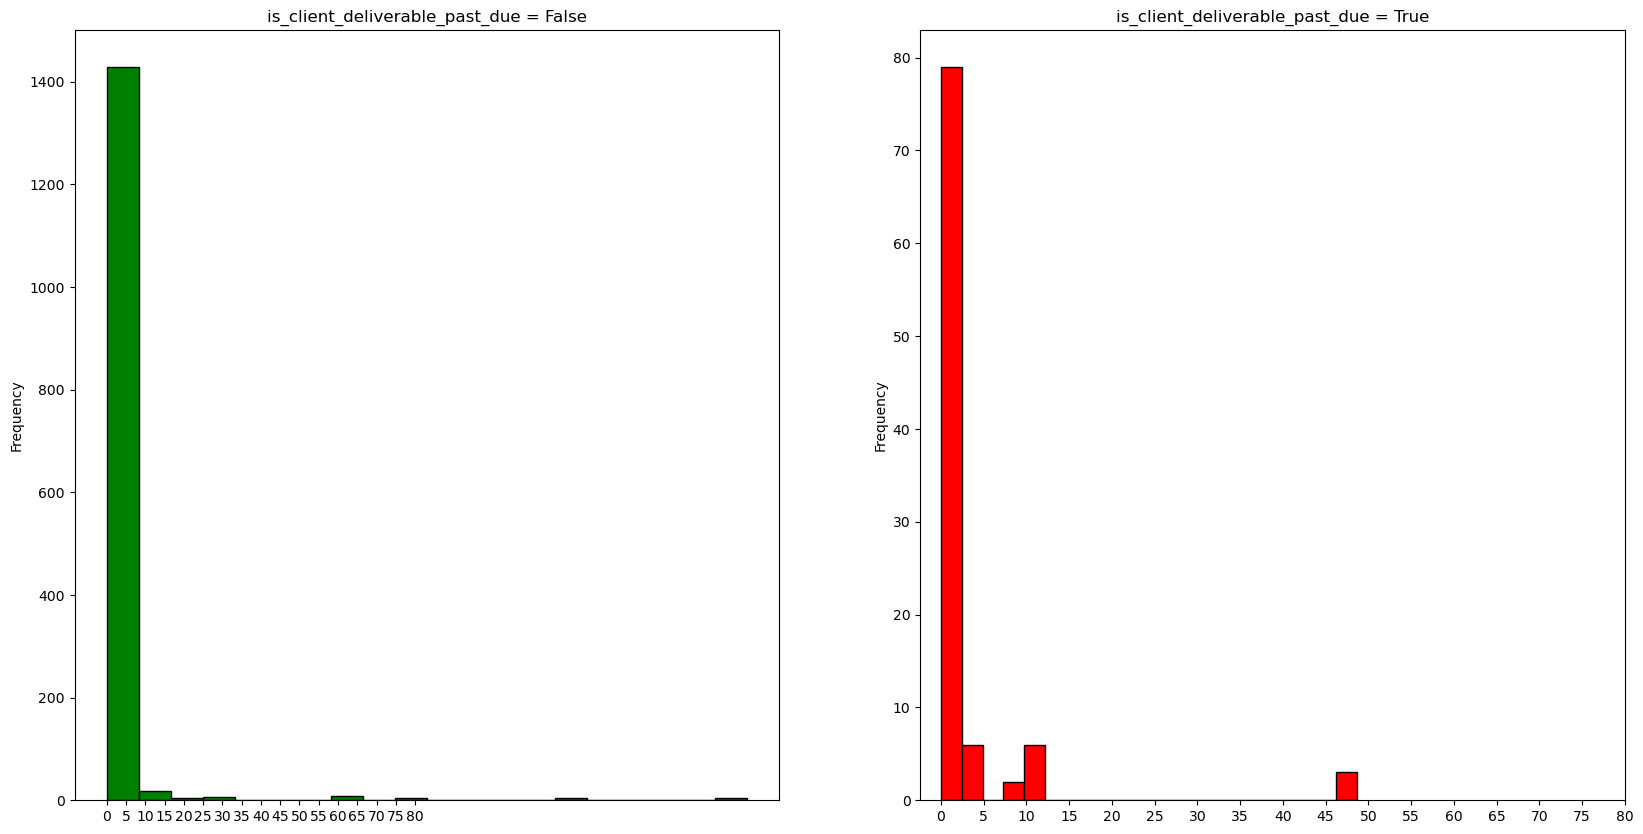

In [48]:
f,ax=plt.subplots(1,2,figsize=(20,10))
requests2[requests2['is_client_deliverable_past_due']==False].average_duration_request_received_to_quoted_business_days.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='green')
ax[0].set_title('is_client_deliverable_past_due = False')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
requests2[requests2['is_client_deliverable_past_due']==True].average_duration_request_received_to_quoted_business_days.plot.hist(ax=ax[1],bins=20,edgecolor='black',color='red')
ax[1].set_title('is_client_deliverable_past_due = True')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

This has very sparse data. So it would be difficult to make a connection between time takes for quote to be given and OTD success. However, with the given data looks like quotes were usually given quickly, but seems to not be significant for there to be deliverable to be made on time. There is a lot of variance in quotes even though deliverable was completed on time.

Last, but not least, let's see if any request level columns correlate with OTD. With what we have seen so far, the assumption is not much except for service line.f
* change is_client_deliverable_past_due to OTD (swap True -> 0)
* change categorical data in service line to numeric 

In [49]:
requests2['is_client_deliverable_past_due'] = requests2['is_client_deliverable_past_due'].astype(int)
requests2['OTD'] = requests2['is_client_deliverable_past_due'].replace({0:1, 1:0})

requests2.drop(columns=['is_client_deliverable_past_due'], inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [50]:
categorical_features=identify_nominal_columns(requests2)
categorical_features

['service_line']

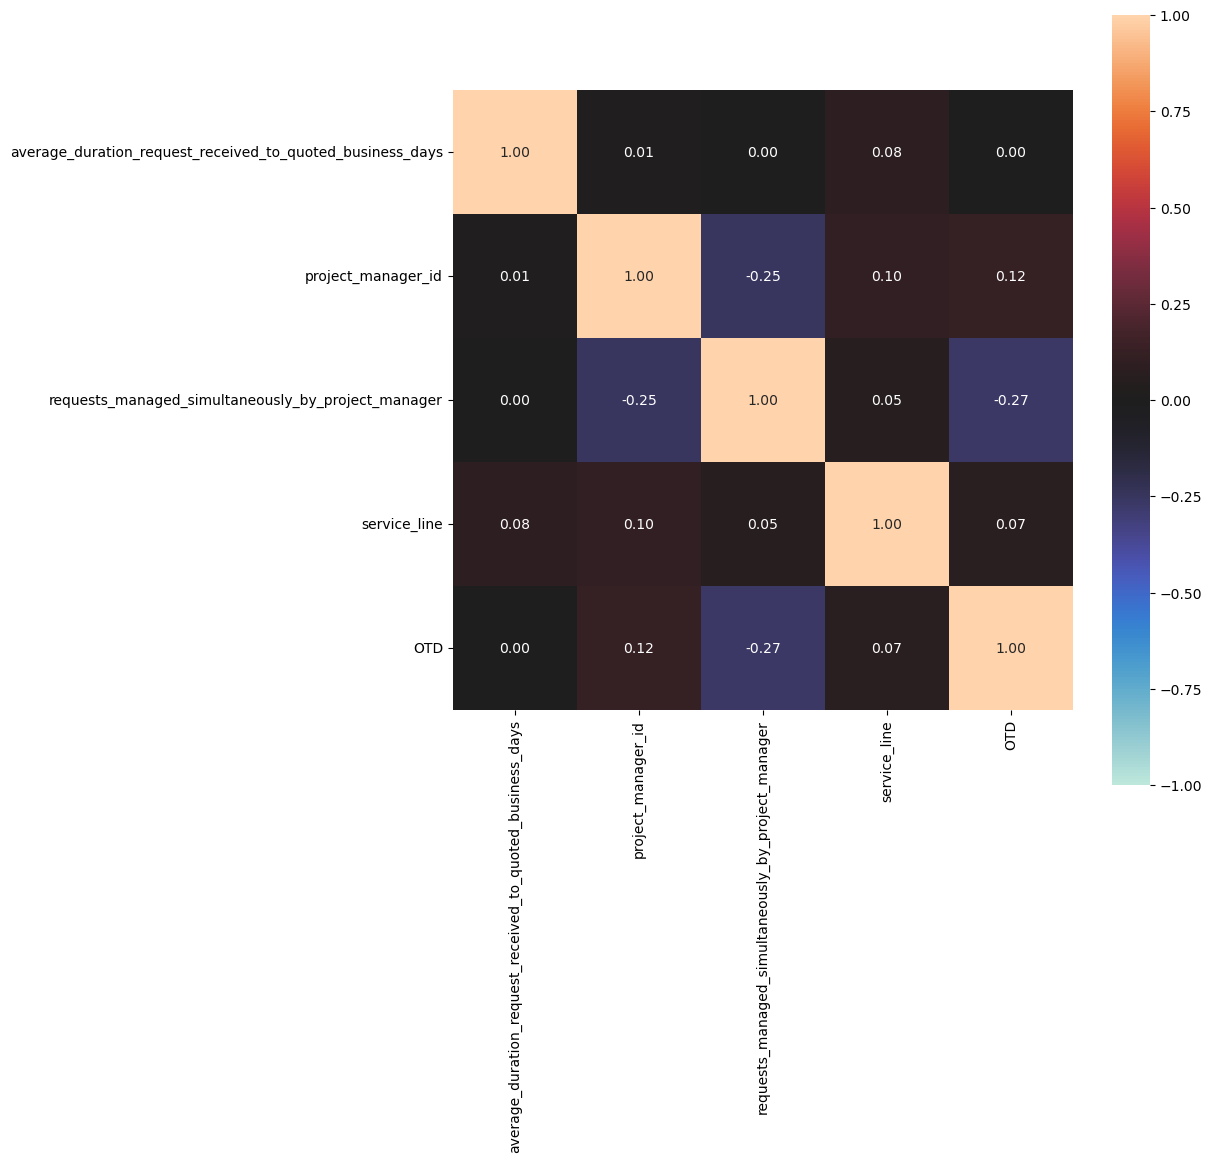

{'corr':                                                     average_duration_request_received_to_quoted_business_days  \
 average_duration_request_received_to_quoted_bus...                                           1.000000           
 project_manager_id                                                                           0.013899           
 requests_managed_simultaneously_by_project_manager                                           0.000164           
 service_line                                                                                 0.083999           
 OTD                                                                                          0.001574           
 
                                                     project_manager_id  \
 average_duration_request_received_to_quoted_bus...            0.013899   
 project_manager_id                                            1.000000   
 requests_managed_simultaneously_by_project_manager           -0.253197   
 servi

In [51]:
complete_correlation= associations(requests2, figsize=(10,10))
complete_correlation

There are no high correlations to note not even with OTD. 

## Translation Task

*  Within each deliverable there are multiple tasks including translation tasks. 
*  Each translation task has its own linquist/translator. 
*  Because each row is unique according to client_deliverable_id, all connected tasks are one task to one deliverable (many to many rel)

In [52]:
translation_task.head()

,translations_for_client_by_supplier_to_date,source_language_locale_code,target_language_locale_code,content_specialty,translation_supplier_id,is_client_deliverable_past_due
0,1,en-US,ja-JP,Chemistry,Pantheon_11922,False
1,33,en-US,sq-AL,Chemistry,Pantheon_5920,False
2,13,en-US,el-GR,Chemistry,Pantheon_5881,False
3,16,en-US,lt-LT,Chemistry,Pantheon_5922,False
4,8,en-US,pt-PT,Chemistry,Pantheon_6813,False


In [53]:
translation_task.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99697 entries, 0 to 99696
Data columns (total 6 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   translations_for_client_by_supplier_to_date  99697 non-null  int64 
 1   source_language_locale_code                  99697 non-null  object
 2   target_language_locale_code                  99697 non-null  object
 3   content_specialty                            99697 non-null  object
 4   translation_supplier_id                      99697 non-null  object
 5   is_client_deliverable_past_due               99697 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 3.9+ MB


In [54]:
translation_task.isnull().sum()

translations_for_client_by_supplier_to_date    0
source_language_locale_code                    0
target_language_locale_code                    0
content_specialty                              0
translation_supplier_id                        0
is_client_deliverable_past_due                 0
dtype: int64

In [55]:
translation_task.describe()

,translations_for_client_by_supplier_to_date
count,99697.000000
mean,2298.606307
std,2991.265194
min,1.000000
25%,237.000000
50%,1255.000000
75%,3069.000000
max,14089.000000


** Data Types:
    
This set is predominantly categorical.

* Categorical: source_language_locale_code, target_language_locale_code, content_specialty, translation_supplier_id, is_client_deliverable_past_due
* Numeric: translations_for_client_by_supplier_to_date

### source_language_locale_code

In [56]:
task_otd = translation_task.loc[translation_task['is_client_deliverable_past_due'] == False]
task_nonotd = translation_task.loc[translation_task['is_client_deliverable_past_due'] == True]

<AxesSubplot:>

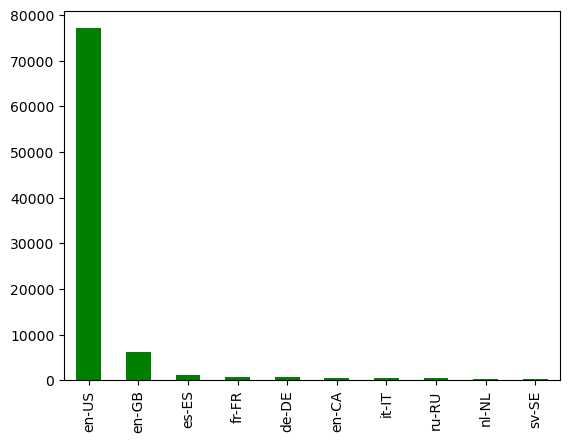

In [57]:
task_otd.source_language_locale_code.value_counts()[:10].plot(kind='bar', color = 'green')

<AxesSubplot:>

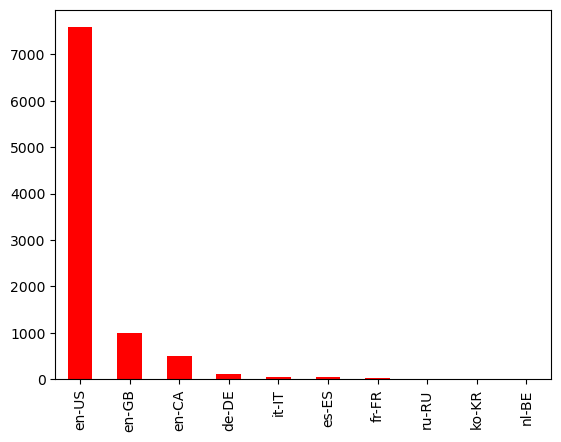

In [58]:
task_nonotd.source_language_locale_code.value_counts()[:10].plot(kind='bar', color = 'red')

Majority of Source Language is English (US and GB).

In [59]:
translation_task[['source_language_locale_code', 'is_client_deliverable_past_due']].groupby(['source_language_locale_code'], as_index=False).mean().sort_values(by='is_client_deliverable_past_due', ascending=False)

,source_language_locale_code,is_client_deliverable_past_due
53,tgl-PH,1.000000
38,nl-BE,0.647059
4,bs-Latn-BA,0.600000
11,en-CA,0.517350
41,prs-AF,0.500000
22,fr-BE,0.428571
9,de-DE,0.153946
12,en-GB,0.136238
18,es-MX,0.133333
10,el-GR,0.121951


tgl-PH	has perfect positive correlation of non-OTD deliverable!

###  target_language_locale_code

In [60]:
translation_task.groupby(['target_language_locale_code','is_client_deliverable_past_due'])['is_client_deliverable_past_due'].count()

target_language_locale_code  is_client_deliverable_past_due
af-ZA                        False                             133
                             True                               10
am-ET                        False                             125
                             True                                3
ar-AE                        False                             181
                                                              ... 
zh-Hant                      True                              304
zh-SG                        False                              11
                             True                               24
zul-ZA                       False                             153
                             True                                3
Name: is_client_deliverable_past_due, Length: 263, dtype: int64

In [61]:
translation_task[['target_language_locale_code', 'is_client_deliverable_past_due']].groupby(['target_language_locale_code'], as_index=False).mean().sort_values(by='is_client_deliverable_past_due', ascending=False)

,target_language_locale_code,is_client_deliverable_past_due
38,en-SG,1.000000
159,zh-SG,0.685714
35,en-IE,0.600000
129,sq-AL,0.588235
63,fr-XC,0.553086
...,...,...
126,sna-zw,0.000000
127,som-SO,0.000000
128,sot-ZA,0.000000
14,aze-AZ,0.000000


Very interesting! en-SG has high likelihood of non-OTD with perfect correlation!! 

### context_specialty

In [62]:
translation_task[['content_specialty', 'is_client_deliverable_past_due']].groupby(['content_specialty'], as_index=False).mean().sort_values(by='is_client_deliverable_past_due', ascending=False)

,content_specialty,is_client_deliverable_past_due
28,Product,0.315068
9,Financial Statements,0.253731
8,Financial Operations,0.250000
22,Other,0.225583
34,Transfer Pricing_Do not Use,0.200000
29,Product/Service,0.196888
33,Technical Specifications,0.172414
11,Informational,0.146585
15,LS - Medical Devices_DO NOT USE,0.131280
14,LIT: Technical_DO NOT USE,0.130435


If you're a product specialty, Financial related high likelihood of non-OTD. Other is ambiguous.

### translation_supplier_id

In [63]:
translation_task[['translation_supplier_id', 'is_client_deliverable_past_due']].groupby(['translation_supplier_id'], as_index=False).mean().sort_values(by='is_client_deliverable_past_due', ascending=False)

,translation_supplier_id,is_client_deliverable_past_due
898,Pantheon_25830,1.0
966,Pantheon_28022,1.0
198,Pantheon_1432,1.0
567,Pantheon_19681,1.0
682,Pantheon_22157,1.0
...,...,...
663,Pantheon_21975,0.0
662,Pantheon_2195,0.0
661,Pantheon_21948,0.0
660,Pantheon_21941,0.0


There are a bunch of linquists who have delivered non-OTD...We can verify this with our heatmap.

### translations_for_client_by_supplier_to_date

In [64]:
translation_task.translations_for_client_by_supplier_to_date.describe()

count    99697.000000
mean      2298.606307
std       2991.265194
min          1.000000
25%        237.000000
50%       1255.000000
75%       3069.000000
max      14089.000000
Name: translations_for_client_by_supplier_to_date, dtype: float64

Huge amount of variance. See if there is a difference when data is split between those with OTD and non-OTD deliverables.

Let's split between OTD and non-OTD.

In [65]:
task_otd = translation_task.loc[translation_task['is_client_deliverable_past_due'] == False]
task_nonotd = translation_task.loc[translation_task['is_client_deliverable_past_due'] == True]

Text(0.5, 0, 'OTD - translations for client by supplier to date')

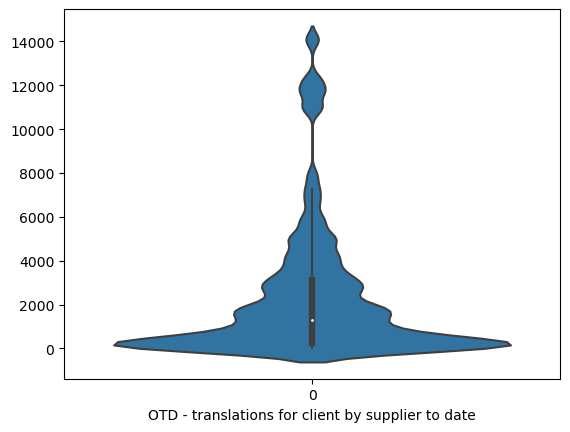

In [66]:
sns.violinplot(task_otd.translations_for_client_by_supplier_to_date)
plt.xlabel("OTD - translations for client by supplier to date")

<AxesSubplot:>

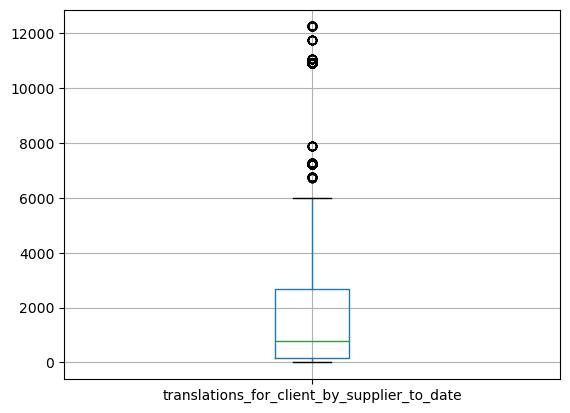

In [67]:
# sns.violinplot(task_nonotd.translations_for_client_by_supplier_to_date)
# plt.xlabel("non-OTD - translations for client by supplier to date")

task_nonotd.boxplot(column='translations_for_client_by_supplier_to_date')

### Correlations

* change target variable to OTD with 1 = OTD and 0 = non-OTD



In [68]:
list(translation_task)

['translations_for_client_by_supplier_to_date',
 'source_language_locale_code',
 'target_language_locale_code',
 'content_specialty',
 'translation_supplier_id',
 'is_client_deliverable_past_due']

In [69]:
translation_task['is_client_deliverable_past_due'] = translation_task['is_client_deliverable_past_due'].astype(int)
translation_task['OTD'] = translation_task['is_client_deliverable_past_due'].replace({0:1, 1:0})

translation_task.drop(columns=['is_client_deliverable_past_due'], inplace=True)

In [70]:
categorical_features=identify_nominal_columns(translation_task)
categorical_features

['source_language_locale_code',
 'target_language_locale_code',
 'content_specialty',
 'translation_supplier_id']

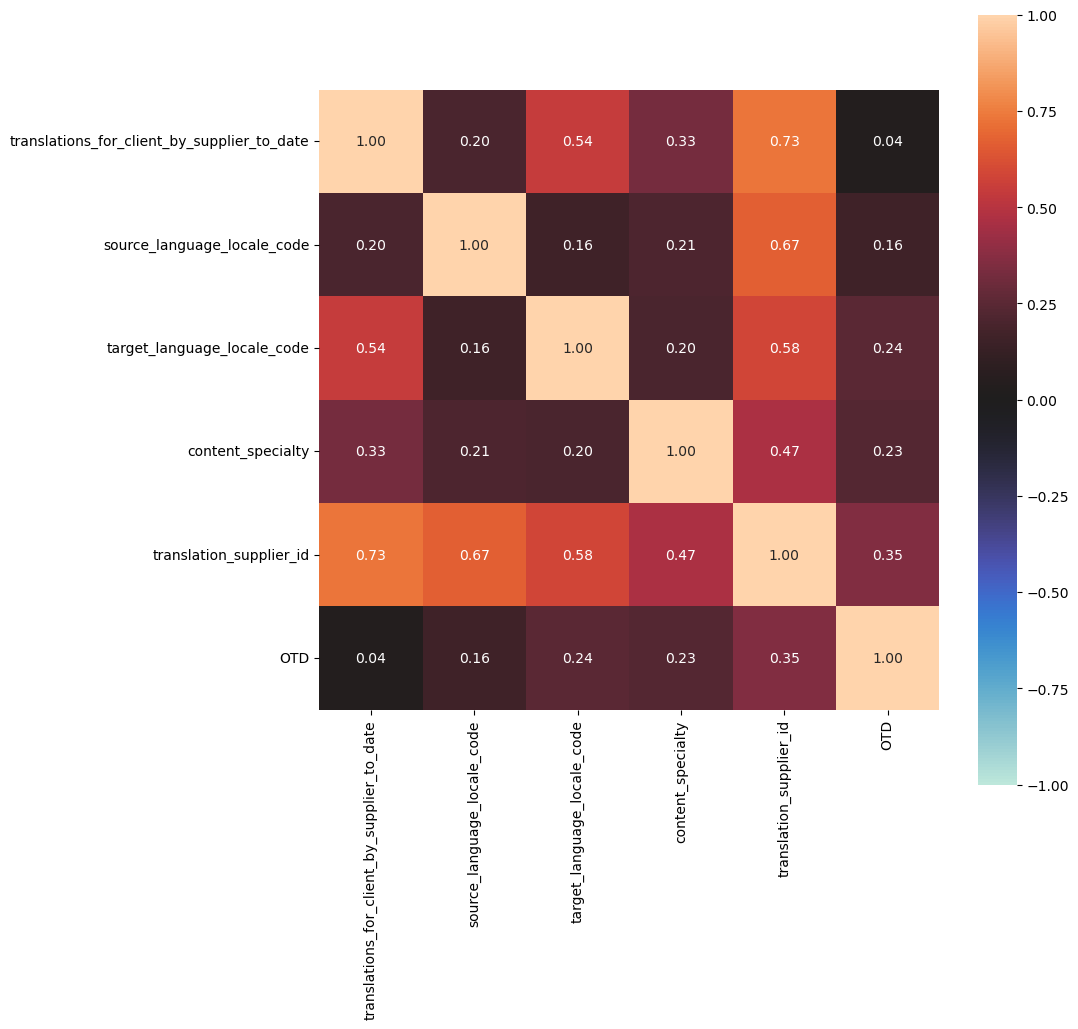

{'corr':                                              translations_for_client_by_supplier_to_date  \
 translations_for_client_by_supplier_to_date                                     1.000000   
 source_language_locale_code                                                     0.201961   
 target_language_locale_code                                                     0.539789   
 content_specialty                                                               0.325396   
 translation_supplier_id                                                         0.727445   
 OTD                                                                             0.035761   
 
                                              source_language_locale_code  \
 translations_for_client_by_supplier_to_date                     0.201961   
 source_language_locale_code                                     1.000000   
 target_language_locale_code                                     0.162213   
 content_specialty             

In [71]:
complete_correlation= associations(translation_task, figsize=(10,10))
complete_correlation

Finally, there is some correlation!

Highest correlations: 
* translations_for_client_by_supplier_to_date - translation_supplier_id
* source_language_locale_code - translation_supplier_id
* target_language_locale_code - translation_supplier_id
* content specialty - translation_supplier_id
* OTD - translation_supplier_id


Highest correlation with target variable: translation/linguist assigned to the deliverable!